In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
tf.keras.backend.clear_session()

In [30]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [31]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [32]:
subject = 'Roraima - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_RR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Roraima - IDH,Roraima - Consumo de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - Desemprego,Roraima - value
0,2003-1,0.734916,6.920,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,6.128460e+06,332580.202821,12.101540,5.339136e+06,8.263084,0.294583
1,2003-2,0.734957,7.476,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,6.136622e+06,332914.755543,12.103485,5.342057e+06,8.257123,0.296505
2,2003-3,0.734998,8.659,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,6.144784e+06,333249.308265,12.105429,5.344978e+06,8.251161,0.298178
3,2003-4,0.735038,7.259,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,6.152947e+06,333583.860987,12.107373,5.347899e+06,8.245199,0.299598
4,2003-5,0.735079,6.786,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,6.161109e+06,333918.413709,12.109318,5.350821e+06,8.239238,0.300965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,9.133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.581560
236,2022-9,NaN,10.622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.579849
237,2022-10,NaN,10.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.577718
238,2022-11,NaN,10.258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.575950


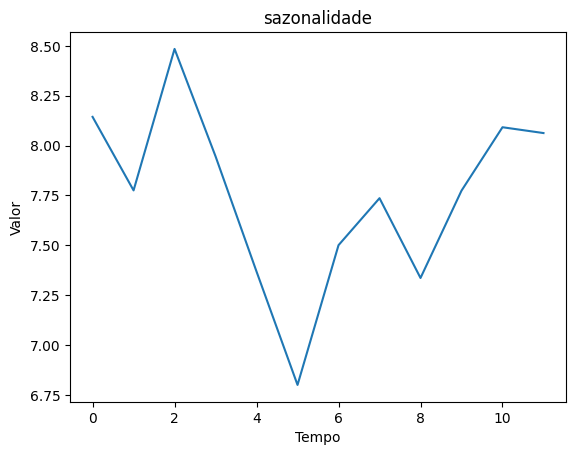

,sazonalidade
sazonalidade,
0,8.143825
1,7.775350
2,8.484300
3,7.945950
4,7.368600
5,6.800600
6,7.500850
7,7.736300
8,7.336450


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Roraima - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - Desemprego,Roraima - value,sazonalidade,Roraima - Consumo de Cimento (t)
0,2003-1,0.734916,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,6.128460e+06,332580.202821,12.101540,5.339136e+06,8.263084,0.294583,8.143825,6.920
1,2003-2,0.734957,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,6.136622e+06,332914.755543,12.103485,5.342057e+06,8.257123,0.296505,7.775350,7.476
2,2003-3,0.734998,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,6.144784e+06,333249.308265,12.105429,5.344978e+06,8.251161,0.298178,8.484300,8.659
3,2003-4,0.735038,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,6.152947e+06,333583.860987,12.107373,5.347899e+06,8.245199,0.299598,7.945950,7.259
4,2003-5,0.735079,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,6.161109e+06,333918.413709,12.109318,5.350821e+06,8.239238,0.300965,7.368600,6.786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.581560,7.736300,9.133
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.579849,7.336450,10.622
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.577718,7.774000,10.300
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.575950,8.091850,10.258


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      2.928
1      2.118
2      2.876
3      3.091
4      2.684
       ...  
235      NaN
236      NaN
237      NaN
238      NaN
239      NaN
Name: Roraima - Consumo de Cimento (t), Length: 240, dtype: float64

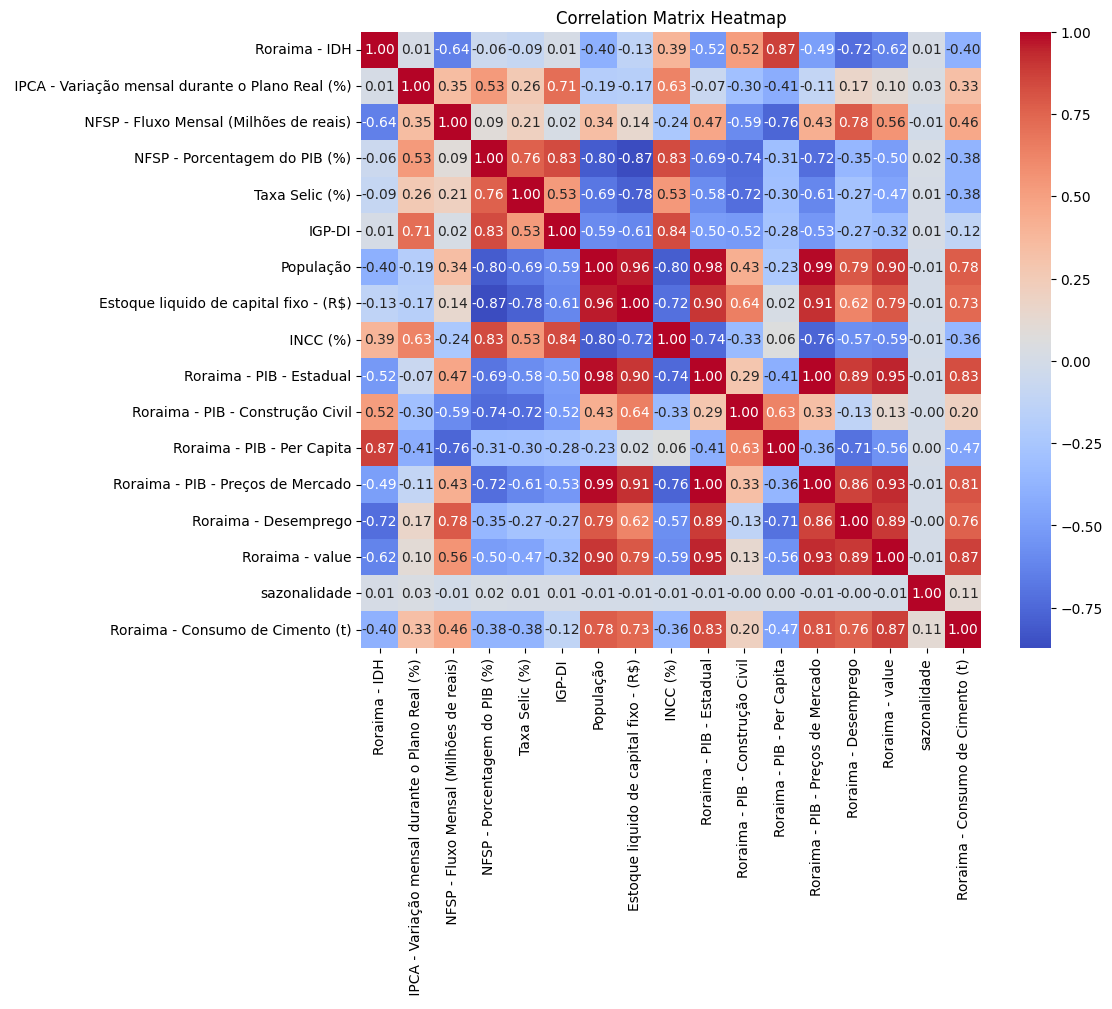

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Roraima - IDH,1.199619e+07
1,IPCA - Variação mensal durante o Plano Real (%),1.401971e+03
2,NFSP - Fluxo Mensal (Milhões de reais),2.664934e+02
3,NFSP - Porcentagem do PIB (%),2.157594e+02
4,Taxa Selic (%),5.517092e+01
5,IGP-DI,3.528173e+02
6,População,3.180684e+06
7,Estoque liquido de capital fixo - (R$),1.038596e+07
8,INCC (%),1.250634e+03
9,Roraima - PIB - Estadual,1.255663e+07


In [40]:
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 2


,Roraima - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - Desemprego,Roraima - value,sazonalidade
0,0.734916,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,6.128460e+06,332580.202821,8.263084,0.294583,8.143825
1,0.734957,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,6.136622e+06,332914.755543,8.257123,0.296505,7.775350
2,0.734998,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,6.144784e+06,333249.308265,8.251161,0.298178,8.484300
3,0.735038,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,6.152947e+06,333583.860987,8.245199,0.299598,7.945950
4,0.735079,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,6.161109e+06,333918.413709,8.239238,0.300965,7.368600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.732982,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,7.563255e+06,340226.550786,10.596927,0.425379,7.736300
176,0.732888,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,7.563682e+06,340258.149767,10.605982,0.426321,7.336450
177,0.732795,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,7.564109e+06,340289.748748,10.615037,0.427293,7.774000
178,0.732701,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,7.564537e+06,340321.347730,10.624092,0.428276,8.091850


In [41]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - Desemprego,Roraima - value
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.604030,-2.527122,-0.626096,-0.775860
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.586813,-2.444919,-0.631425,-0.741691
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.569595,-2.362716,-0.636754,-0.711965
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.552377,-2.280513,-0.642084,-0.686715
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.535160,-2.198310,-0.647413,-0.662422
...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,1.422581,-0.648335,1.460134,1.548839
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,1.423482,-0.640571,1.468228,1.565583
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,1.424383,-0.632807,1.476323,1.582863
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,1.425284,-0.625043,1.484417,1.600336


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - Desemprego,Roraima - value
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.604030,-2.527122,-0.626096,-0.775860
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.586813,-2.444919,-0.631425,-0.741691
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.569595,-2.362716,-0.636754,-0.711965
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.552377,-2.280513,-0.642084,-0.686715
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.535160,-2.198310,-0.647413,-0.662422
...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,1.375271,-0.650811,1.489348,1.390972
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,1.383471,-0.661186,1.472173,1.402104
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,1.391672,-0.671561,1.454999,1.412964
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,1.399873,-0.681935,1.437824,1.423545


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      2.928
1      2.118
2      2.876
3      3.091
4      2.684
       ...  
163    7.275
164    9.468
165    7.970
166    7.866
167    8.108
Name: Roraima - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 12)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - Desemprego,Roraima - value
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,0.971298,0.350031,1.220008,0.892491
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,0.987108,0.272399,1.249467,0.922755
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,1.002918,0.194768,1.278926,0.953306
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,1.018728,0.117136,1.308385,0.983035
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,1.034538,0.039504,1.337844,1.013013
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,1.050348,-0.038128,1.367303,1.041055
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,1.066158,-0.115759,1.396762,1.069343
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,1.081967,-0.193391,1.426221,1.094347
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,1.097777,-0.271023,1.455680,1.118813
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,1.113587,-0.348655,1.485140,1.143311


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 12)

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh',
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    mape = np.mean(df_results["Error"])/np.mean(df_results["Target"])

    return df_results, predictions, mape

In [51]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions, mape = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(f"\n\Results: {i} ___________________________________________\n")
            display(df_results.T)
            display(mape)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [52]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[1157834970, 4149147635, 3207340308, 2367474120, 733904302, 2435245308, 2486932982, 1741744603, 2164119807, 1661756937]


Step: 0 ___________________________________________
val_loss: 3.969984769821167
winner_seed: 1157834970


Step: 1 ___________________________________________
val_loss: 3.6427199840545654
winner_seed: 4149147635


Step: 2 ___________________________________________
val_loss: 2.963695764541626
winner_seed: 3207340308


Step: 3 ___________________________________________
val_loss: 3.1909220218658447


Step: 4 ___________________________________________
val_loss: 3.3503923416137695


Step: 5 ___________________________________________
val_loss: 3.1737492084503174


Step: 6 ___________________________________________
val_loss: 2.9448635578155518
winner_seed: 2486932982


Step: 7 ___________________________________________
val_loss: 3.7323503494262695


Step: 8 ___________________________________________
val_loss: 2.9731438159942627


Step: 9 _____________________________

'\n\\Results: 0 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,6.943458,6.952116,6.948009,6.953674,6.972263,7.006148,7.008489,7.060263,7.108441,7.134807,7.163082,7.182222
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,2.964542,3.770884,3.676991,3.639326,3.708737,0.880852,2.742512,2.593737,2.313559,4.025193,3.327919,3.042778


0.30289816730403524

[3606087149, 3054896746, 2765797829, 2318876951, 2453443146, 1196639938, 3682156379, 2939037035, 353520516, 2222351670]


Step: 0 ___________________________________________
val_loss: 3.119861602783203
winner_seed: 3606087149


Step: 1 ___________________________________________
val_loss: 2.7959883213043213
winner_seed: 3054896746


Step: 2 ___________________________________________
val_loss: 3.1745362281799316


Step: 3 ___________________________________________
val_loss: 3.7187600135803223


Step: 4 ___________________________________________
val_loss: 3.122399091720581


Step: 5 ___________________________________________
val_loss: 3.22640061378479


Step: 6 ___________________________________________
val_loss: 3.230135440826416


Step: 7 ___________________________________________
val_loss: 2.94384765625


Step: 8 ___________________________________________
val_loss: 2.744044303894043
winner_seed: 353520516


Step: 9 ___________________________________________
val_loss: 3.8301880

'\n\\Results: 1 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,7.383893,7.487698,7.597104,7.703351,7.791552,7.815696,7.843053,7.801764,7.678124,7.57218,7.551644,7.616368
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,2.524107,3.235302,3.027896,2.889649,2.889448,0.071304,1.907948,1.852237,1.743876,3.58782,2.939356,2.608632


0.2417237235816341

[2717786286, 3781099974, 1748274387, 3798645081, 1212731809, 176271465, 4052824406, 1492864851, 1882286050, 3686276501]


Step: 0 ___________________________________________
val_loss: 3.069864511489868
winner_seed: 2717786286


Step: 1 ___________________________________________
val_loss: 2.6666343212127686
winner_seed: 3781099974


Step: 2 ___________________________________________
val_loss: 3.1774277687072754


Step: 3 ___________________________________________
val_loss: 3.1433727741241455


Step: 4 ___________________________________________
val_loss: 3.4738564491271973


Step: 5 ___________________________________________
val_loss: 3.0135269165039062


Step: 6 ___________________________________________
val_loss: 2.807755947113037


Step: 7 ___________________________________________
val_loss: 3.1146881580352783


Step: 8 ___________________________________________
val_loss: 3.153986930847168


Step: 9 ___________________________________________
val_loss: 3.9616193771362305
1/1 [

'\n\\Results: 2 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,7.227528,7.362421,7.512037,7.684511,7.879507,8.073594,8.243677,8.427138,8.587956,8.722938,8.866718,9.008863
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,2.680472,3.360579,3.112963,2.908489,2.801493,0.186594,1.507323,1.226862,0.834044,2.437062,1.624282,1.216137


0.19729442530295654

[2780208093, 4096107405, 1581097893, 347158437, 490052195, 3266636400, 1649232301, 261080148, 2382971825, 613097177]


Step: 0 ___________________________________________
val_loss: 3.1123299598693848
winner_seed: 2780208093


Step: 1 ___________________________________________
val_loss: 6.3677449226379395


Step: 2 ___________________________________________
val_loss: 3.09421706199646
winner_seed: 1581097893


Step: 3 ___________________________________________
val_loss: 3.1069061756134033


Step: 4 ___________________________________________
val_loss: 2.8531246185302734
winner_seed: 490052195


Step: 5 ___________________________________________
val_loss: 3.761340856552124


Step: 6 ___________________________________________
val_loss: 2.994333505630493


Step: 7 ___________________________________________
val_loss: 4.539395332336426


Step: 8 ___________________________________________
val_loss: 3.0897016525268555


Step: 9 ___________________________________________
val_loss: 3.0603

'\n\\Results: 3 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,7.556365,7.625507,7.674933,7.717073,7.747098,7.752642,7.76992,7.767437,7.765712,7.77314,7.798089,7.821864
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,2.351635,3.097492,2.950067,2.875927,2.933902,0.134358,1.981081,1.886563,1.656288,3.386859,2.692911,2.403137


0.23406720381904314

[3563705767, 836521676, 3578682861, 2701977363, 4098595997, 3474112827, 178426125, 757645054, 4196389249, 1889047973]


Step: 0 ___________________________________________
val_loss: 3.2522921562194824
winner_seed: 3563705767


Step: 1 ___________________________________________
val_loss: 4.036059856414795


Step: 2 ___________________________________________
val_loss: 2.9319655895233154
winner_seed: 3578682861


Step: 3 ___________________________________________
val_loss: 3.039720296859741


Step: 4 ___________________________________________
val_loss: 4.0859270095825195


Step: 5 ___________________________________________
val_loss: 3.1166365146636963


Step: 6 ___________________________________________
val_loss: 2.574744701385498
winner_seed: 178426125


Step: 7 ___________________________________________
val_loss: 3.5785164833068848


Step: 8 ___________________________________________
val_loss: 3.9357099533081055


Step: 9 ___________________________________________
val_loss: 3.5

'\n\\Results: 4 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,7.834255,8.011223,8.090957,8.02513,7.758967,7.283348,6.707845,6.57908,6.698414,6.809416,6.851686,6.852883
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,2.073745,2.711777,2.534043,2.56787,2.922033,0.603652,3.043155,3.074921,2.723586,4.350584,3.639315,3.372117


0.27754953231962703

[4039628645, 1099373072, 3592501502, 1966327250, 1106863439, 1888725444, 2024420370, 685457970, 2421472565, 2145814534]


Step: 0 ___________________________________________
val_loss: 3.1863627433776855
winner_seed: 4039628645


Step: 1 ___________________________________________
val_loss: 3.104945659637451
winner_seed: 1099373072


Step: 2 ___________________________________________
val_loss: 2.9882678985595703
winner_seed: 3592501502


Step: 3 ___________________________________________
val_loss: 3.1097612380981445


Step: 4 ___________________________________________
val_loss: 3.0401313304901123


Step: 5 ___________________________________________
val_loss: 3.7183399200439453


Step: 6 ___________________________________________
val_loss: 3.458744764328003


Step: 7 ___________________________________________
val_loss: 3.654019832611084


Step: 8 ___________________________________________
val_loss: 2.9027178287506104
winner_seed: 2421472565


Step: 9 ______________________________

'\n\\Results: 5 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,6.65869,6.618429,6.587445,6.570823,6.568483,6.580677,6.588448,6.626921,6.680548,6.745829,6.82699,6.911151
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,3.24931,4.104571,4.037555,4.022177,4.112517,1.306323,3.162553,3.027079,2.741452,4.414171,3.664011,3.313849


0.3397916629418357

[1657480146, 4241245477, 2109443977, 1823847376, 3860148084, 1055971532, 1931476265, 202165100, 572139489, 15376476]


Step: 0 ___________________________________________
val_loss: 2.205707311630249
winner_seed: 1657480146


Step: 1 ___________________________________________
val_loss: 3.0924103260040283


Step: 2 ___________________________________________
val_loss: 4.331581115722656


Step: 3 ___________________________________________
val_loss: 3.1181554794311523


Step: 4 ___________________________________________
val_loss: 2.774479866027832


Step: 5 ___________________________________________
val_loss: 3.052913188934326


Step: 6 ___________________________________________
val_loss: 3.575556993484497


Step: 7 ___________________________________________
val_loss: 3.053987979888916


Step: 8 ___________________________________________
val_loss: 3.035107135772705


Step: 9 ___________________________________________
val_loss: 3.2152395248413086
1/1 [==============================]

'\n\\Results: 6 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,8.152203,8.377098,8.562061,8.743064,8.89819,9.018504,9.119446,9.2288,9.300304,9.364609,9.445263,9.517958
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,1.755797,2.345901,2.062939,1.849936,1.782809,1.131504,0.631555,0.4252,0.121696,1.795391,1.045737,0.707043


0.1292561839089841

[2586233132, 3907849380, 3764379695, 273646690, 2692355436, 1578836258, 2963895355, 3012205821, 3760333835, 4079165841]


Step: 0 ___________________________________________
val_loss: 3.0559239387512207
winner_seed: 2586233132


Step: 1 ___________________________________________
val_loss: 3.201228618621826


Step: 2 ___________________________________________
val_loss: 3.0613579750061035


Step: 3 ___________________________________________
val_loss: 3.2830514907836914


Step: 4 ___________________________________________
val_loss: 2.647646903991699
winner_seed: 2692355436


Step: 5 ___________________________________________
val_loss: 2.8852691650390625


Step: 6 ___________________________________________
val_loss: 3.0734469890594482


Step: 7 ___________________________________________
val_loss: 3.0246331691741943


Step: 8 ___________________________________________
val_loss: 3.5127952098846436


Step: 9 ___________________________________________
val_loss: 3.1378910541534424
1/1 

'\n\\Results: 7 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,7.37027,7.395185,7.421603,7.447407,7.456407,7.387436,7.392586,7.318037,7.212863,7.280933,7.461899,7.667903
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,2.53773,3.327814,3.203397,3.145594,3.224593,0.499564,2.358415,2.335963,2.209137,3.879066,3.029101,2.557097


0.26673936780881696

[1185572938, 2805958068, 2897110455, 615565813, 1719425899, 1496289189, 3212624366, 68817261, 4213868952, 2138103115]


Step: 0 ___________________________________________
val_loss: 3.2772653102874756
winner_seed: 1185572938


Step: 1 ___________________________________________
val_loss: 3.3293886184692383


Step: 2 ___________________________________________
val_loss: 3.197549343109131
winner_seed: 2897110455


Step: 3 ___________________________________________
val_loss: 3.10831356048584
winner_seed: 615565813


Step: 4 ___________________________________________
val_loss: 3.0442919731140137
winner_seed: 1719425899


Step: 5 ___________________________________________
val_loss: 3.335859775543213


Step: 6 ___________________________________________
val_loss: 3.2301700115203857


Step: 7 ___________________________________________
val_loss: 2.281994104385376
winner_seed: 68817261


Step: 8 ___________________________________________
val_loss: 3.0858068466186523


Step: 9 _____________

'\n\\Results: 8 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,7.762105,7.834311,7.918344,8.01049,8.110386,8.208776,8.285419,8.380233,8.451246,8.515358,8.613702,8.736224
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,2.145895,2.888688,2.706656,2.58251,2.570614,0.321775,1.465582,1.273767,0.970754,2.644642,1.877298,1.488776


0.1893738301931001

[769607849, 3994744331, 1383093004, 3443930496, 767402408, 2598261321, 237984219, 3729602398, 2680244153, 646345713]


Step: 0 ___________________________________________
val_loss: 3.2595298290252686
winner_seed: 769607849


Step: 1 ___________________________________________
val_loss: 3.287978410720825


Step: 2 ___________________________________________
val_loss: 3.5503861904144287


Step: 3 ___________________________________________
val_loss: 2.778125762939453
winner_seed: 3443930496


Step: 4 ___________________________________________
val_loss: 2.4991347789764404
winner_seed: 767402408


Step: 5 ___________________________________________
val_loss: 3.110342264175415


Step: 6 ___________________________________________
val_loss: 2.9162137508392334


Step: 7 ___________________________________________
val_loss: 3.0672948360443115


Step: 8 ___________________________________________
val_loss: 3.2627217769622803


Step: 9 ___________________________________________
val_loss: 2.943

'\n\\Results: 9 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,7.570408,7.562391,7.538458,7.519104,7.504746,7.491814,7.513328,7.532884,7.547321,7.577695,7.624228,7.678688
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,2.337592,3.160609,3.086542,3.073896,3.176253,0.395186,2.237672,2.121116,1.874679,3.582304,2.866772,2.546313


0.25147732686807495

'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,7.445918,7.522638,7.585096,7.637464,7.668759,7.661864,7.647221,7.672256,7.703093,7.74969,7.82033,7.899413
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,2.462082,3.200362,3.039904,2.955536,3.012241,0.225136,2.103779,1.981744,1.718907,3.41031,2.67067,2.325587


In [53]:
display(mae)
display(mape)

7.667812

0.23447399281188538